BloomTech Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [40]:
%%capture
import sys

# For Google reproducibility
if 'google.colab' in sys.modules:
    DATA_PATH = "/content/drive/My Drive/Kaggle"
    !pip install category_encoders==2.*

    #Connect to remote data
    from google.colab import drive
    drive.mount(DATA_PATH, force_remount=True)

# Local data store on drive D:
else:
    DATA_PATH = "D:/Datafiles/"

In [41]:
# Import Block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#xgboost
from xgboost import XGBClassifier 
# #imblearn
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler
#sklearn
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
# from sklearn.compose import make_column_transformer
# from sklearn.compose import make_column_selector as selector

Part One - Dataset Basics

For this week's modules I am using the asteroid dataset found on Kaggle here: https://www.kaggle.com/datasets/sakhawat18/asteroid-dataset
(This is a cleaner version of the NASA/JPL datasets used in my portfolio projects, as such thoroughness is not needed for the daily projects)

The target for this exercise will be the Potentially Hazardous Asteroid classification feature. 
Unfortunately (or, fortunately for the Earth) this feature is heavily unbalanced in favor of 'no' so we will need to adjust our metrics.

This is an unbalanced binary classification problem, so we will evaluate balanced accuracy and F1 score, as well as ROC AUC.
We will also evaluate the accuracy of the models trained on synthetically balanced datasets using eg. SMOTE techniques.

The features in this dataset have a lot of redundancy due to having been merged from various sources; additionally there are
many label features which need to be culled for modeling purposes and to prevent cross-leaking. 

Also worthy of note is that the PHA designation is a direct fuction of two features, absolute magnitude ('H') and minimum orbit intercept 
distance ('moid'), so models will eventually be compared between the initial inference with the features included, and ones built without 
those features.

In [42]:
# Wrangling Functions

def wrangle(filepath):

    df = pd.read_csv(filepath, index_col=['pdes']) #pdes = primary designation number
    
    #drop extraneous label/index/constant columns
    labels = ['id', 'spkid', 'full_name', 'name', 'prefix', 'orbit_id', 'equinox', 'class']
    df.drop(columns=labels, inplace=True)
    #drop duplicate date/distance columns
    #NOTE: we want consistent Julian dates & AU distances
    labels= ['epoch_mjd', 'epoch_cal', 'tp_cal', 'per_y', 'moid_ld']
    df.drop(columns=labels, inplace=True)
    #drop leaky columns
    labels = ['neo']
    df.drop(columns=labels, inplace=True)

    #drop rows with no target value
    df.dropna(subset=['pha'], inplace=True)

    #convert pha to tidy numeric binary encoding
    df['pha'] = [1 if flag=='Y' else 0 for flag in df['pha']]

    #calculate missing albedo from magnitude
    abdmask =  (df['albedo'].isna() & ~(df['H'].isna() | df['diameter'].isna()))
    df['albedo'].where(~abdmask, ((1329*(10**((-1)*(df['H']/5)))/df['diameter'])**2), inplace=True) 

    # impute remaining missing albedo with standard value
    # see: https://en.wikipedia.org/wiki/Standard_asteroid_physical_characteristics
    df['albedo'].where(~(df['albedo'].isna()), other=0.1, inplace=True)

    # calculate missing diameter values from magnitude
    diamask = (df['diameter'].isna() & ~(df['H'].isna() | df['albedo'].isna()))
    df['diameter'].where(~diamask, (1329/(np.sqrt(df['albedo'])))*(10**((-1)*(df['H']/5))), inplace=True)

    #impute missing diameter sigma values
    #replacing with maximum error as we are using derived diameter values
    df['diameter_sigma'].where(~(df['diameter_sigma'].isna()), other=df['diameter_sigma'].max(), inplace=True)

    #finally, calculate missing magnitude values from albedo and diameter
    hmask = (df['H'].isna() & ~(df['albedo'].isna() | df['diameter'].isna()))
    df['H'].where(~hmask, 5 * (np.log10((1329/(df['diameter'] * np.sqrt(df['albedo']))))), inplace=True)

    #any remaining missing values must be dropped
    df.dropna(inplace=True)

    return df

In [43]:
df = wrangle(DATA_PATH + "/Asteroids/dataset.csv")

print(df.shape)
print("")
print(df.info())

c:\Users\Jeff\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(936499, 30)

<class 'pandas.core.frame.DataFrame'>
Index: 936499 entries, 1 to 2678 T-3
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   pha             936499 non-null  int64  
 1   H               936499 non-null  float64
 2   diameter        936499 non-null  float64
 3   albedo          936499 non-null  float64
 4   diameter_sigma  936499 non-null  float64
 5   epoch           936499 non-null  float64
 6   e               936499 non-null  float64
 7   a               936499 non-null  float64
 8   q               936499 non-null  float64
 9   i               936499 non-null  float64
 10  om              936499 non-null  float64
 11  w               936499 non-null  float64
 12  ma              936499 non-null  float64
 13  ad              936499 non-null  float64
 14  n               936499 non-null  float64
 15  tp              936499 non-null  float64
 16  per             936499 non-null  float64
 17 

Part Two - Baseline Modeling

Baseline accuracy of ~0.998 is a bit problematic, so we will try 
1. Different scoring methods
2. Some basic resampling 
before building the initial models

In [44]:
# Create two datasets to model, with/without the H (magnitude) + moid columns
# easy mode = default columns, hard mode = without, model must infer from other data
df_hard = df.drop(columns=['H', 'moid'])

X = df.drop(columns='pha')
y = df['pha']

X_h = df_hard.drop(columns='pha')
y_h = df_hard['pha']

#naive baseline scores
model_dum = DummyClassifier(strategy='prior').fit(X, y)
dum_pred = model_dum.predict(X)
baseline_acc = accuracy_score(y, dum_pred)
print(baseline_acc)
base_bal_acc = balanced_accuracy_score(y, dum_pred)
print(base_bal_acc)


0.9977939111520674
0.5


In [45]:
#split datasets into train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_h_train, X_h_test, y_h_train, y_h_test = train_test_split(X_h, y_h, test_size=0.2, random_state=42)

#get majority/minority class splits for resampling
class_mask = (df['pha'] == 1)
X_train_min, X_train_maj = X_train.loc[class_mask], X_train.loc[~class_mask]
X_h_train_min, X_h_train_maj = X_h_train.loc[class_mask], X_h_train.loc[~class_mask]

#evenly over- and under-sample dataset to create balanced training set
pha_y, pha_n = y_train.value_counts(sort=True, ascending=True)

train_midp_sample_1 = X_train_min.sample(((pha_n + pha_y)//2), replace=True)
y_sample_1 = pd.Series([1] * len(train_midp_sample_1))
train_midp_sample_0 = X_train_maj.sample(((pha_n + pha_y)//2)+1, replace=False)
y_sample_0 = pd.Series([0] * len(train_midp_sample_0))
X_train_res =  train_midp_sample_1.append(train_midp_sample_0, ignore_index=True)
y_train_res = pd.concat([y_sample_1, y_sample_0], ignore_index=True)

pha_h_y, pha_h_n = y_h_train.value_counts(sort=True, ascending=True)

train_h_midp_sample_1 = X_h_train_min.sample(((pha_n + pha_y)//2), replace=True)
y_h_sample_1 = pd.Series([1] * len(train_h_midp_sample_1))
train_h_midp_sample_0 = X_h_train_maj.sample(((pha_h_n + pha_h_y)//2)+1, replace=False)
y_h_sample_0 = pd.Series([0] * len(train_h_midp_sample_0))
X_h_train_res =  train_h_midp_sample_1.append(train_h_midp_sample_0, ignore_index=True)
y_h_train_res = pd.concat([y_h_sample_1, y_h_sample_0], ignore_index=True)

#check for deformed arrays
print(X_train.shape)
print(X_train_res.shape)
print(y_train.shape)
print(y_train_res.shape)

print(X_h_train.shape)
print(X_h_train_res.shape)
print(y_h_train.shape)
print(y_h_train_res.shape)


(749199, 29)
(749199, 29)
(749199,)
(749199,)
(749199, 27)
(749199, 27)
(749199,)
(749199,)


BloomTech Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [46]:
# Initial models
# No need for Imputer or Encoder transformers
model_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
model_rf = make_pipeline(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))

print("######### Original Dataset Distributions ########")

print("*Full Data Columns*")

model_lr.fit(X_train, y_train)
lr_acc = accuracy_score(y_test, model_lr.predict(X_test))
print("LR Model Accuracy: ", lr_acc)
lr_acc_bal = balanced_accuracy_score(y_test, model_lr.predict(X_test))
print("LR Model Balanced Accuracy: ", lr_acc_bal)

model_rf.fit(X_train, y_train)
rf_acc = accuracy_score(y_test, model_rf.predict(X_test))
print("RF Model Accuracy: ", rf_acc)
rf_acc_bal = balanced_accuracy_score(y_test, model_rf.predict(X_test))
print("RF Model Balanced Accuracy: ", rf_acc_bal)

print("*Limited Data Columns*")

model_lr.fit(X_h_train, y_h_train)
lr_h_acc = accuracy_score(y_h_test, model_lr.predict(X_h_test))
print("LR Model Accuracy: ", lr_h_acc)
lr_h_acc_bal = balanced_accuracy_score(y_h_test, model_lr.predict(X_h_test))
print("LR Model Balanced Accuracy: ", lr_h_acc_bal)

model_rf.fit(X_h_train, y_h_train)
rf_h_acc = accuracy_score(y_h_test, model_rf.predict(X_h_test))
print("RF Model Accuracy: ", rf_h_acc)
rf_h_acc_bal = balanced_accuracy_score(y_h_test, model_rf.predict(X_h_test))
print("RF Model Balanced Accuracy: ", rf_h_acc_bal)

print("######### Resampled Dataset Distributions ########")

print("*Full Data Columns*")

model_lr.fit(X_train_res, y_train_res)
lr_acc = accuracy_score(y_test, model_lr.predict(X_test))
print("LR Model Accuracy: ", lr_acc)
lr_acc_bal = balanced_accuracy_score(y_test, model_lr.predict(X_test))
print("LR Model Balanced Accuracy: ", lr_acc_bal)

model_rf.fit(X_train_res, y_train_res)
rf_acc = accuracy_score(y_test, model_rf.predict(X_test))
print("RF Model Accuracy: ", rf_acc)
rf_acc_bal = balanced_accuracy_score(y_test, model_rf.predict(X_test))
print("RF Model Balanced Accuracy: ", rf_acc_bal)

print("*Limited Data Columns*")

model_lr.fit(X_h_train_res, y_h_train_res)
lr_h_acc = accuracy_score(y_h_test, model_lr.predict(X_h_test))
print("LR Model Accuracy: ", lr_h_acc)
lr_h_acc_bal = balanced_accuracy_score(y_h_test, model_lr.predict(X_h_test))
print("LR Model Balanced Accuracy: ", lr_h_acc_bal)

model_rf.fit(X_h_train_res, y_h_train_res)
rf_h_acc = accuracy_score(y_h_test, model_rf.predict(X_h_test))
print("RF Model Accuracy: ", rf_h_acc)
rf_h_acc_bal = balanced_accuracy_score(y_h_test, model_rf.predict(X_h_test))
print("RF Model Balanced Accuracy: ", rf_h_acc_bal)


######### Original Dataset Distributions ########
*Full Data Columns*
LR Model Accuracy:  0.9982594767752269
LR Model Balanced Accuracy:  0.6768255810981356
RF Model Accuracy:  0.999893219434063
RF Model Balanced Accuracy:  0.9828633334716426
*Limited Data Columns*
LR Model Accuracy:  0.9974319273892152
LR Model Balanced Accuracy:  0.524940230108523
RF Model Accuracy:  0.9983342231713828
RF Model Balanced Accuracy:  0.6985016999579061
######### Resampled Dataset Distributions ########
*Full Data Columns*
LR Model Accuracy:  0.9938601174586226
LR Model Balanced Accuracy:  0.9957839861213723
RF Model Accuracy:  0.9999145755472504
RF Model Balanced Accuracy:  0.9976794341772203
*Limited Data Columns*
LR Model Accuracy:  0.9791404164442071
LR Model Balanced Accuracy:  0.9895457610429086
RF Model Accuracy:  0.9978270154831821
RF Model Balanced Accuracy:  0.8770511498510682


Part Three - Permutation Importances and Gradient Boosting

From the last part two things are clear:
1. The additional H and moid data columns dramatically affect the power of the model, 
    to the point they could be considered 'leaky'.
2. Resampling to balance the dataset greatly improves the fit of the final model.

So for this next part we are going to focus on just the limited (_h) and resampled datasets
and try to improve the models based on them.

In [47]:
#reconstruct the models for part 3 and get their feature importances

model_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
model_rf = make_pipeline(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))

model_lr.fit(X_h_train_res, y_h_train_res)
model_rf.fit(X_h_train_res, y_h_train_res)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

Text(0.5, 0, 'coefficient')

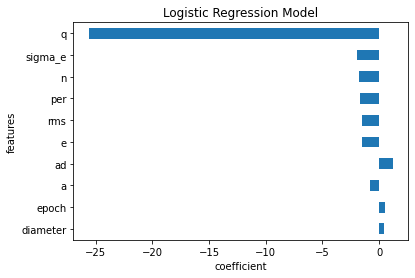

In [48]:
lr_imp = model_lr.named_steps['logisticregression'].coef_[0]
pd.Series(data=lr_imp, index=X_h.columns).sort_values(key=abs).tail(10).plot(kind='barh')
plt.title('Logistic Regression Model')
plt.ylabel('features')
plt.xlabel('coefficient')


Text(0.5, 0, 'importance')

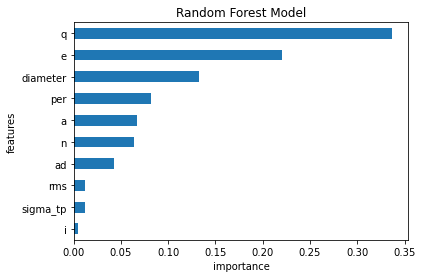

In [49]:
rf_imp = model_rf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=rf_imp, index=X_h.columns).sort_values(key=abs).tail(10).plot(kind='barh')
plt.title('Random Forest Model')
plt.ylabel('features')
plt.xlabel('importance')

Looking at the above plots, both models prioritize q (perihelion distance) as well as a collection of other features.
It's worth noting the tree-based model is more balanced in its features while the LR model includes some questionable
coefficients (_sigma columns represent error values) that may not actually be contributing.

In [50]:
# Split testing values into validation and testing sets for permutation tuning
X_h_val_p, X_h_test_p, y_h_val_p, y_h_test_p = train_test_split(X_h_test, y_h_test, train_size=0.5, random_state=42)

#generate permutation importance arrays
lr_imp_p = permutation_importance(model_lr, X_h_val_p, y_h_val_p, scoring='balanced_accuracy', n_jobs=-1, random_state=42)
rf_imp_p = permutation_importance(model_rf, X_h_val_p, y_h_val_p, scoring='balanced_accuracy', n_jobs=-1, random_state=42)

data_lr_p = {'imp_mean':lr_imp_p['importances_mean'], 'imp_std':lr_imp_p['importances_std']}
df_lr_p = pd.DataFrame(data_lr_p, index=X_h_val_p.columns, columns=data_lr_p)
data_rf_p = {'imp_mean':rf_imp_p['importances_mean'], 'imp_std':lr_imp_p['importances_std']}
df_rf_p = pd.DataFrame(data_rf_p, index=X_h_val_p.columns, columns=data_rf_p)

Text(0.5, 0, 'perm. importance')

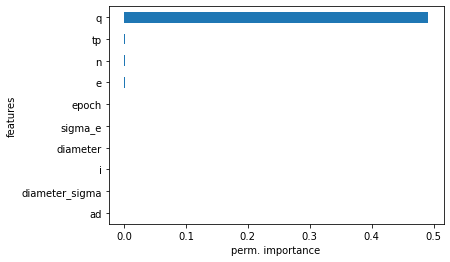

In [51]:
df_lr_p['imp_mean'].sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('perm. importance')

Text(0.5, 0, 'perm. importance')

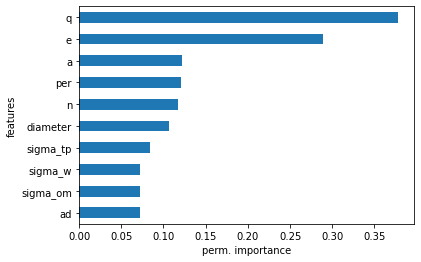

In [52]:
df_rf_p['imp_mean'].sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('perm. importance')

This confirms something is likely going wrong in the Logistic Regression model, so we 
are going to drop it going forward.
Now, onto the least relevant data columns in the remaining model:

Text(0.5, 0, 'perm. importance')

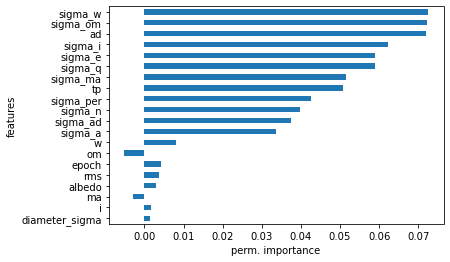

In [53]:
df_rf_p['imp_mean'].sort_values(key=abs).head(20).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('perm. importance')

From the above we can see that it should be possible to drop some columns to reduce noise.
We can 1. Drop columns below a certain importance threshold and 2. Drop columns whose
corresponding error columns (sigma) are ranked with higher importance (ie the noise 
in the data is being ranked as more important than the data, so both are probably irrelevant)

In [55]:
#create final train, val, test sets by dropping noise columns

noise_cols = ['sigma_tp', 'sigma_w', 'sigma_q', 'sigma_e', 'sigma_ma', 'sigma_om', 'sigma_i', 
                'tp', 'rms', 'i', 'w', 'albedo', 'om', 'epoch', 'ma', 'diameter_sigma']

X_train_final = X_h_train_res.drop(columns=noise_cols)
X_val_final = X_h_val_p.drop(columns=noise_cols)
X_test_final = X_h_test_p.drop(columns=noise_cols)
y_train_final, y_val_final, y_test_final = y_h_train_res, y_h_val_p, y_h_test_p

In [56]:
# Build a new Gradient Boosted model using the improved dataset

#setup for hyperparam tuning
tun_params = {"n_estimators": np.arange(70, 180, 10),
                "max_depth": np.arange(3, 16, 1),
                "min_child_weight": np.arange(1, 10, 2),
                "learning_rate": np.arange(0.05, 0.40, 0.05)}
#fit new xgb model to new dataset
xgb_inst = XGBClassifier(random_state=42) #no further pipeline needed
model_xgb = RandomizedSearchCV(xgb_inst, tun_params, cv=5, n_iter=10, scoring='balanced_accuracy', 
                                n_jobs=-1, random_state=42, verbose=1)
model_xgb.fit(X_train_final, y_train_final)

#display tuned hyperparameters and new model accuracy
print("Tuned params: ", model_xgb.best_params_)
print("Best Balanced Accuracy Score: ", model_xgb.best_score_)
#bring back old score for comparison
print("Previous best RF model score: ", rf_h_acc_bal)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuned params:  {'n_estimators': 170, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.3}
Best Balanced Accuracy Score:  0.9983582487987187
Previous best RF model score:  0.8770511498510682


In [57]:
# Build the same model on the old dataset for comparison

model_xgb.fit(X_h_train_res, y_h_train_res)

#display tuned hyperparameters and new model accuracy
print("Tuned params (unpruned dataset): ", model_xgb.best_params_)
print("Best Balanced Accuracy Score (unpruned dataset): ", model_xgb.best_score_)
#bring back old score for comparison
print("Previous best RF model score: ", rf_h_acc_bal)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuned params (unpruned dataset):  {'n_estimators': 170, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.3}
Best Balanced Accuracy Score (unpruned dataset):  0.9991070475173519
Previous best RF model score:  0.8770511498510682
